In [11]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration


In [12]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám soubor: ../ground_truth/groundtruth_2012-01-22.csv...


/tmp/ipykernel_18261/1350448941.py:21: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=None, names=['time', 'x', 'y', 'z', 'r', 'p', 'h'])



✅ Data seřazena do formátu [px, vx, py, vy]. Shape: (5210, 4)
Měření vygenerována (Simulace GPS+Odo). Shape: torch.Size([5210, 4])
  -> Šum polohy (std): 26.46 m
  -> Šum rychlosti (std): 0.10 m/s
Dataset rozdělen: Train=3126, Val=1042, Test=1042


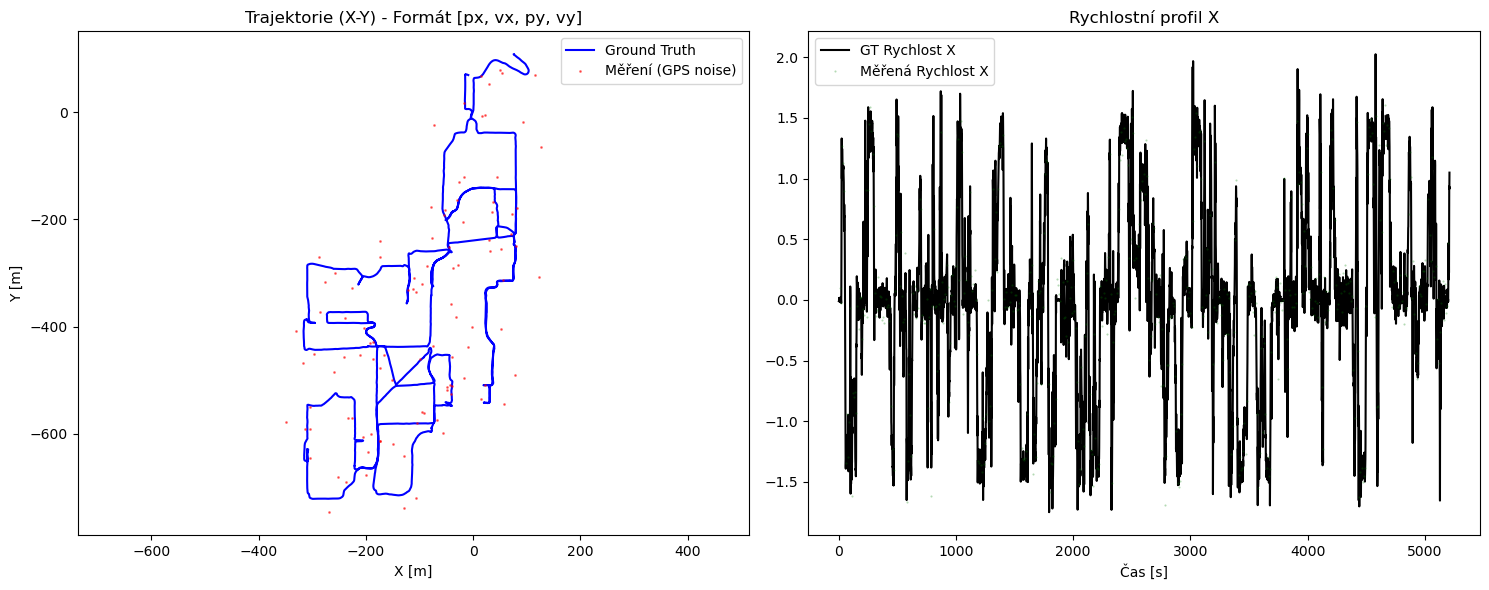

In [13]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# === 1. KONFIGURACE ===
file_path = '../ground_truth/groundtruth_2012-01-22.csv' 
DT = 1.0  # Časový krok

# Parametry šumu pro generování trénovacích dat (Simulace měření)
# Abychom replikovali autory, musíme vygenerovat měření, která odpovídají
# jejich matici R: diag([700, 0.01, 700, 0.01]).
# Tedy: Velký šum na pozici (GPS), malý na rychlosti (Odometrie).
std_pos = np.sqrt(700.0)  # cca 26.4 metrů
std_vel = np.sqrt(0.01)   # 0.1 m/s

# === 2. NAČTENÍ A PŘÍPRAVA SUROVÝCH DAT ===
print(f"Načítám soubor: {file_path}...")
try:
    df = pd.read_csv(file_path, header=None, names=['time', 'x', 'y', 'z', 'r', 'p', 'h'])
    raw_time = df['time'].values / 1e6
    raw_time = raw_time - raw_time[0]
    raw_pos = df[['x', 'y']].values
    
    # --- Resampling (Interpolace) ---
    t_resampled = np.arange(0, raw_time[-1], DT)
    interp_func = interp1d(raw_time, raw_pos, kind='linear', axis=0, fill_value="extrapolate")
    pos_resampled = interp_func(t_resampled) # [N, 2] -> (x, y)
    
    # --- Výpočet rychlosti (Derivace) ---
    vel_resampled = np.zeros_like(pos_resampled)
    vel_resampled[1:] = (pos_resampled[1:] - pos_resampled[:-1]) / DT
    vel_resampled[0] = vel_resampled[1]
    
    # === 3. SKLÁDÁNÍ DO FORMÁTU AUTORŮ [px, vx, py, vy] ===
    # Toto je ta klíčová změna!
    # Sloupec 0: Pozice X
    # Sloupec 1: Rychlost X
    # Sloupec 2: Pozice Y
    # Sloupec 3: Rychlost Y
    
    GT_DATA = np.stack((
        pos_resampled[:, 0], # px
        vel_resampled[:, 0], # vx
        pos_resampled[:, 1], # py
        vel_resampled[:, 1]  # vy
    ), axis=1)
    
    print(f"\n✅ Data seřazena do formátu [px, vx, py, vy]. Shape: {GT_DATA.shape}")

    # === 4. KONVERZE DO PYTORCH A GENEROVÁNÍ MĚŘENÍ ===
    X_target = torch.from_numpy(GT_DATA).float()
    N_samples = X_target.shape[0]
    
    # Generování šumu měření podle specifikace autorů
    # noise_std vektor: [std_px, std_vx, std_py, std_vy]
    noise_std_vec = torch.tensor([std_pos, std_vel, std_pos, std_vel])
    
    # Y = X + Noise
    # Rozšiřujeme noise_std_vec na velikost dat
    noise = torch.randn(N_samples, 4) * noise_std_vec
    Y_measured = X_target + noise
    
    print(f"Měření vygenerována (Simulace GPS+Odo). Shape: {Y_measured.shape}")
    print(f"  -> Šum polohy (std): {std_pos:.2f} m")
    print(f"  -> Šum rychlosti (std): {std_vel:.2f} m/s")

    # === 5. ROZDĚLENÍ TRAIN / VAL / TEST ===
    n_train = int(0.6 * N_samples)
    n_val = int(0.2 * N_samples)
    n_test = N_samples - n_train - n_val
    
    train_input = Y_measured[:n_train]
    train_target = X_target[:n_train]
    
    val_input = Y_measured[n_train:n_train+n_val]
    val_target = X_target[n_train:n_train+n_val]
    
    test_input = Y_measured[n_train+n_val:]
    test_target = X_target[n_train+n_val:]
    
    print(f"Dataset rozdělen: Train={len(train_input)}, Val={len(val_input)}, Test={len(test_input)}")

    # === 6. VIZUALIZACE KONTROLY ===
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pro vizualizaci musíme brát správné sloupce z nového GT_DATA
    # X=0, VX=1, Y=2, VY=3
    
    # Trajektorie (X vs Y) -> Sloupec 0 vs Sloupec 2
    ax[0].plot(GT_DATA[:, 0], GT_DATA[:, 2], 'b-', label='Ground Truth')
    # Vykreslíme i kousek měření (jen pro představu šumu), bereme jen každý 50. bod ať to není čmouha
    ax[0].plot(Y_measured[::50, 0], Y_measured[::50, 2], 'r.', markersize=2, alpha=0.5, label='Měření (GPS noise)')
    ax[0].set_title('Trajektorie (X-Y) - Formát [px, vx, py, vy]')
    ax[0].set_xlabel('X [m]')
    ax[0].set_ylabel('Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    
    # Rychlost X (VX) -> Sloupec 1
    ax[1].plot(t_resampled, GT_DATA[:, 1], 'k-', label='GT Rychlost X')
    ax[1].plot(t_resampled[::10], Y_measured[::10, 1], 'g.', markersize=1, alpha=0.3, label='Měřená Rychlost X')
    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Soubor '{file_path}' nenalezen.")
except Exception as e:
    print(f"❌ CHYBA: {e}")

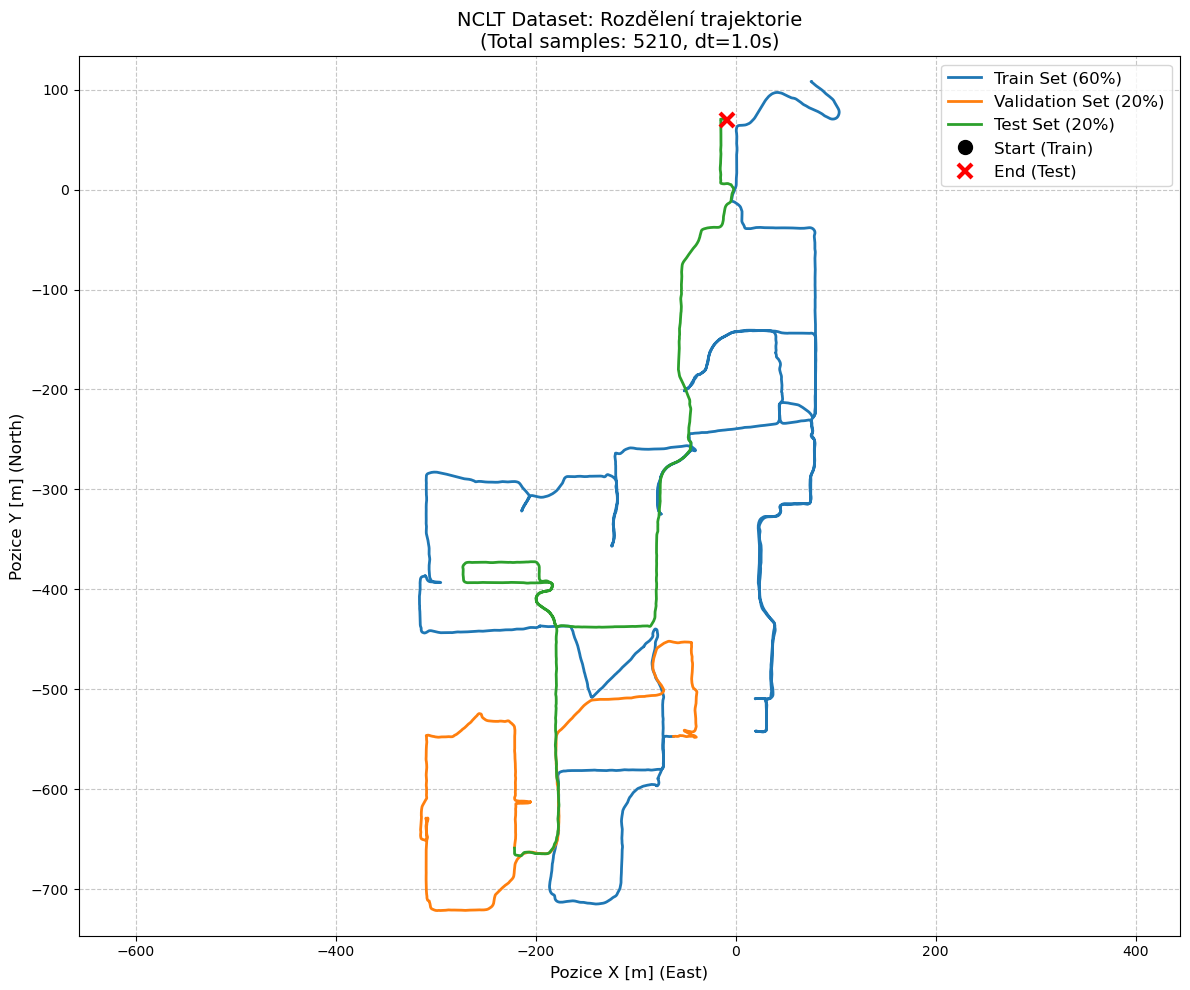

In [14]:
import matplotlib.pyplot as plt

# === VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# 1. Vykreslení Trénovací části
# Musíme převést tenzory zpět na numpy (a pro jistotu na CPU, kdyby byly na GPU)
plt.plot(train_target[:, 0].cpu().numpy(), 
         train_target[:, 2].cpu().numpy(), 
         label='Train Set (60%)', color='#1f77b4', linewidth=2)

# 2. Vykreslení Validační části
plt.plot(val_target[:, 0].cpu().numpy(), 
         val_target[:, 2].cpu().numpy(), 
         label='Validation Set (20%)', color='#ff7f0e', linewidth=2)

# 3. Vykreslení Testovací části
plt.plot(test_target[:, 0].cpu().numpy(), 
         test_target[:, 2].cpu().numpy(), 
         label='Test Set (20%)', color='#2ca02c', linewidth=2)

# Zvýraznění začátku a konce
plt.plot(train_target[0, 0].cpu(), train_target[0, 2].cpu(), 'ko', markersize=10, label='Start (Train)')
plt.plot(test_target[-1, 0].cpu(), test_target[-1, 2].cpu(), 'rx', markersize=10, markeredgewidth=3, label='End (Test)')

# Formátování grafu
plt.title(f'NCLT Dataset: Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [15]:
import torch
import math
import Systems # Předpokládám, že toto je tvůj modul s třídou DynamicSystem

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################
### Design Parameters ###
### (Dle autorů)      ###
#########################

# 1. Rozměry
# Stav: [px, vx, py, vy] (Všimni si pořadí!)
m = 4 
n = 4 
delta_t = 1.0 # Sampling NCLT datasetu

# 2. Dynamika (F)
# x_{t+1} = x_t + v_t * dt
# v_{t+1} = v_t
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

# Vytvoření 4x4 matice pro X a Y osy
# Výsledek je blokově diagonální, což znamená pořadí stavů: [px, vx, py, vy]
F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H)
# Měříme vše: [px, vx, py, vy]
H_design = torch.eye(n).float()

# 4. Šum procesu (Q)
# Autoři definují Q diagonálně závislé na čase
lambda_q_mod = 1.0
Q_dim = torch.diagflat(torch.tensor([delta_t, delta_t]))
Q_design = (lambda_q_mod**2) * torch.block_diag(Q_dim, Q_dim).float()

# 5. Šum měření (R) - TOTO JE KLÍČOVÉ PRO REPLIKACI
# 700 = Obrovská chyba polohy (GPS) -> Filtr ji bude potlačovat
# 0.01 = Malá chyba rychlosti (Odometrie) -> Filtr jí bude věřit
# Pořadí odpovídá stavům: [Pos_X, Vel_X, Pos_Y, Vel_Y]
R_design = torch.tensor([[700.0, 0.0,   0.0,   0.0],
                         [0.0,   0.01,  0.0,   0.0],
                         [0.0,   0.0,   700.0, 0.0],
                         [0.0,   0.0,   0.0,   0.01]]).float()

# 6. Počáteční podmínky
# Autoři začínají na nule
m1x_0 = torch.zeros(m, 1).float()      # Mean
m2x_0 = torch.eye(m).float() * 1e-5

print("\nInicializuji systém dle parametrů KalmanNet (Author's replication)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"R (diagonal): {torch.diagonal(R_design)}")

# === INICIALIZACE SYSTÉMŮ ===

# Sys True (Generativní model - pokud bychom generovali syntetická data)
# Pro NCLT data se toto tolik nepoužije (data načítáme), ale pro konzistenci nastavíme stejně.
sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

# Sys Model (To, co ví KalmanNet/Filtr)
sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].")


Inicializuji systém dle parametrů KalmanNet (Author's replication)...
Dimenze stavu: 4, Dimenze měření: 4
R (diagonal): tensor([7.0000e+02, 1.0000e-02, 7.0000e+02, 1.0000e-02])
... Systémy inicializovány.
POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].


In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# === 1. KONFIGURACE ===
TRAIN_SEQ_LEN = 50    # Délka sekvence pro RNN
VAL_SEQ_LEN = 200
TEST_SEQ_LEN = n_test
STRIDE = 10     # Posun okna (pro trénink s překryvem)
BATCH_SIZE = 128 # Velikost dávky

def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory [Total_Len, Dim] na sekvence [N_seq, Seq_Len, Dim].
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        return torch.empty(0, seq_len, X.shape[1]), torch.empty(0, seq_len, Y.shape[1])
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    """
    Filtruje sekvence, které obsahují jakékoliv NaN nebo Inf hodnoty.
    """
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Zkontrolujeme NaN/Inf pro každou sekvenci zvlášť
    # X_seq shape: [N, Seq_Len, Dim] -> reshape na [N, -1] pro kontrolu celého řádku
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    # Maska vadných dat (pokud je chyba v X nebo v Y)
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    
    # Vybereme jen ta dobrá
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí (NaN/Inf). Zbývá: {len(X_clean)}")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("--- ZPRACOVÁNÍ DAT ---")

# === 2. TVORBA SEKVENCÍ A PŘETYPOVÁNÍ ===
# Používáme .float() hned zde, abychom vyřešili Double vs Float error
print("Generuji sekvence...")
train_X_raw, train_Y_raw = create_sequences(train_target.float(), train_input.float(), TRAIN_SEQ_LEN, STRIDE)
val_X_raw, val_Y_raw = create_sequences(val_target.float(), val_input.float(), VAL_SEQ_LEN, VAL_SEQ_LEN)
test_X_raw, test_Y_raw = create_sequences(test_target.float(), test_input.float(), TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT (NAN/INF FILTER) ===
print("\nFiltruji NaN hodnoty...")
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")
# Train: Shuffle=True
train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val/Test: Shuffle=False
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ HOTOVO. Připraveno k tréninku.")
print(f"Batch shape: {next(iter(train_loader))[0].shape}")

--- ZPRACOVÁNÍ DAT ---
Generuji sekvence...

Filtruji NaN hodnoty...
⚠️ Train: Odstraněno 1 vadných sekvencí (NaN/Inf). Zbývá: 307
✅ Val: Data jsou čistá. (5 sekvencí)
✅ Test: Data jsou čistá. (1 sekvencí)

Vytvářím DataLoadery...

✅ HOTOVO. Připraveno k tréninku.
Batch shape: torch.Size([128, 50, 4])


In [17]:
import torch
import torch.optim as optim
import os
from state_NN_models import StateBayesianKalmanNet,StateKalmanNet
from utils import trainer

state_bkn = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10,
                                   output_layer_multiplier=4,num_gru_layers=1,
                                    init_max_dropout=0.8,init_min_dropout=0.6).to(device)

print(state_bkn)


state_knet = state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10,
                                         output_layer_multiplier=4,num_gru_layers=1,
                                         gru_hidden_dim_multiplier=4,
                                         returns_covariance=True).to(device)
print(state_knet)


INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNet(
  (dnn): DNN_BayesianKalmanNet(
    (input_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 128)
    (output_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
    (concrete_dropout2): ConcreteDropout()
  )
)
DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (gru): GRU(640, 128)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=

In [18]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = '../NN_weights/linear_velocity_integration'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'best_MSE_KalmanNet_linear_velocity_integration.pth'
BKN_FILENAME = 'best_BayesianKalmanNet_linear_velocity_integration.pth'  

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

print("\n--- Hotovo ---")

--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/NN_weights/linear_velocity_integration ---

✅ State KalmanNet: Váhy úspěšně načteny z 'best_MSE_KalmanNet_linear_velocity_integration.pth'.
✅ State BKN: Váhy úspěšně načteny z 'best_BayesianKalmanNet_linear_velocity_integration.pth'.

--- Hotovo ---


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Tvůj modul s filtry
from utils import utils # Tvůj modul pro ANEES

# ==============================================================================
# 0. KONFIGURACE
# ==============================================================================
J_SAMPLES = 50  # Počet vzorků pro Monte Carlo Dropout (Ensemble)

# 1. Příprava BKN modelu (Bayesian)
try:
    trained_model_bkn = state_bkn
    # DŮLEŽITÉ: Pro BKN musí být model v režimu TRAIN (aby fungoval Dropout)
    trained_model_bkn.train() 
    print(f"INFO: Bayesian KalmanNet (BKN) připraven (J={J_SAMPLES}).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_knet' (BKN) neexistuje.")

# 2. Příprava KalmanNet modelu (Classic)
try:
    # Předpokládám, že klasický KalmanNet máš v proměnné 'state_knet_classic'
    # Pokud používáš stejnou třídu, jen bez dropoutu, změň název proměnné dle potřeby.
    trained_model_classic = state_knet 
    trained_model_classic.eval() # Klasický KNet chceme v eval módu (vypnout dropout, pokud tam je)
    print(f"INFO: KalmanNet (Classic) připraven.")
except NameError:
    print("VAROVÁNÍ: Proměnná 'state_knet_classic' nenalezena. KNet bude přeskočen.")
    trained_model_classic = None

# 3. Inicializace klasických filtrů pro srovnání
print("Inicializuji EKF, UKF a PF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=100000)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
metrics = {
    'BKN':  {'mse': [], 'anees': []},
    'KNet': {'mse': [], 'anees': []}, # Nová položka pro KalmanNet
    'EKF':  {'mse': [], 'anees': []},
    'UKF':  {'mse': [], 'anees': []},
    'PF':   {'mse': [], 'anees': []}
}

traj_idx = 0
total_trajectories = len(test_loader.dataset)

print(f"\nVyhodnocuji {total_trajectories} sekvencí...")

with torch.no_grad():
    for batch_data in test_loader:
        # Robustní rozbalení dat (x, y, u)
        if len(batch_data) == 3:
            x_true_batch, y_meas_batch, u_input_batch = batch_data
        else:
            x_true_batch, y_meas_batch = batch_data
            # Dummy u_input pokud loader vrací jen x,y (pro jistotu)
            u_input_batch = torch.zeros(x_true_batch.shape[0], x_true_batch.shape[1], 4).to(device)

        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Data jedné trajektorie
            y_seq = y_meas_batch[i].to(device)    # [T, Obs]
            x_true = x_true_batch[i].to(device)   # [T, State]
            seq_len = y_seq.shape[0]

            # Inicializace (Ground Truth)
            init_state_row = x_true[0, :].unsqueeze(0) 
            init_state_col = x_true[0, :].unsqueeze(1) 
            
            # ---------------------------------------------------------
            # 1. Bayesian KalmanNet (BKN) - ENSEMBLE LOGIKA
            # ---------------------------------------------------------
            bkn_init_batch = init_state_row.repeat(J_SAMPLES, 1) 
            trained_model_bkn.reset(batch_size=J_SAMPLES, initial_state=bkn_init_batch)
            samples_history = [bkn_init_batch] 
            
            for t in range(1, seq_len):
                y_t = y_seq[t].unsqueeze(0).repeat(J_SAMPLES, 1) 
                x_est_j, _ = trained_model_bkn.step(y_t) 
                samples_history.append(x_est_j)
            
            full_ensemble = torch.stack(samples_history, dim=0)
            x_bkn_mean = torch.mean(full_ensemble, dim=1) 
            residuals = full_ensemble - x_bkn_mean.unsqueeze(1)
            residuals_perm = residuals.permute(0, 2, 1) 
            P_bkn = torch.bmm(residuals_perm, residuals) / (J_SAMPLES - 1)
            
            metrics['BKN']['mse'].append(F.mse_loss(x_bkn_mean[1:], x_true[1:]).item())
            metrics['BKN']['anees'].append(utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0), x_bkn_mean[1:].unsqueeze(0), P_bkn[1:].unsqueeze(0)))

            # ---------------------------------------------------------
            # 2. KalmanNet (Classic) - Deterministic
            # ---------------------------------------------------------
            if trained_model_classic is not None:
                # Reset modelu (batch_size=1)
                trained_model_classic.reset(batch_size=1, initial_state=init_state_row)
                
                knet_preds = [init_state_row]
                # Počáteční kovariance P0 (musíme ji vzít ze system modelu, protože reset() ji obvykle nevrací)
                knet_covs = [sys_model.P0.unsqueeze(0)] 
                
                for t in range(1, seq_len):
                    y_t = y_seq[t].unsqueeze(0) # [1, Obs_Dim]
                    
                    # ZDE JE ZMĚNA: Nyní očekáváme i P_hat
                    # Předpokládá se, že step() u classic modelu vrací (x, P)
                    x_hat_t, P_hat_t = trained_model_classic.step(y_t)
                    
                    knet_preds.append(x_hat_t)
                    knet_covs.append(P_hat_t)
                
                # Stack do sekvence
                x_knet_seq = torch.stack(knet_preds, dim=0).squeeze(1) # [T, State]
                P_knet_seq = torch.stack(knet_covs, dim=0).squeeze(1)  # [T, State, State]
                
                # Výpočet metrik (od t=1 stejně jako ostatní)
                metrics['KNet']['mse'].append(F.mse_loss(x_knet_seq[1:], x_true[1:]).item())
                metrics['KNet']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), 
                    x_knet_seq[1:].unsqueeze(0), 
                    P_knet_seq[1:].unsqueeze(0)
                ))

            # ---------------------------------------------------------
            # 3. Klasické Filtry (EKF, UKF, PF)
            # ---------------------------------------------------------
            try:
                # EKF
                res_ekf = ekf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['EKF']['mse'].append(F.mse_loss(res_ekf['x_filtered'][1:], x_true[1:]).item())
                metrics['EKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ekf['x_filtered'][1:].unsqueeze(0), res_ekf['P_filtered'][1:].unsqueeze(0)))
                
                # UKF
                res_ukf = ukf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['UKF']['mse'].append(F.mse_loss(res_ukf['x_filtered'][1:], x_true[1:]).item())
                metrics['UKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ukf['x_filtered'][1:].unsqueeze(0), res_ukf['P_filtered'][1:].unsqueeze(0)))
                
                # PF
                res_pf = pf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['PF']['mse'].append(F.mse_loss(res_pf['x_filtered'][1:], x_true[1:]).item())
                metrics['PF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_pf['x_filtered'][1:].unsqueeze(0), res_pf['P_filtered'][1:].unsqueeze(0)))
            
            except Exception as e:
                # print(f"Chyba filtru: {e}")
                pass 

            if traj_idx % 50 == 0:
                print(f"  ... {traj_idx} hotovo")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(l): return np.mean(l) if len(l)>0 else np.nan

print("\n" + "="*90)
print(f"SROVNÁNÍ BKN vs KLASICKÉ FILTRY (NCLT Dataset)")
print("="*90)
print(f"{'Model':<25} | {'MSE':<15} | {'RMSE [m]':<15} | {'ANEES':<15}")
print("-" * 90)

# Přidán KNet do listu
models_to_print = ['BKN', 'KNet', 'EKF', 'UKF', 'PF']
if trained_model_classic is None: models_to_print.remove('KNet')

for name in models_to_print:
    m = avg(metrics[name]['mse'])
    a = avg(metrics[name]['anees'])
    rmse = np.sqrt(m) if not np.isnan(m) else np.nan
    
    print(f"{name:<25} | {m:<15.4f} | {rmse:<15.4f} | {a:<15.4f}")

print("="*90)
print(f"Pozn: Ideální ANEES pro state_dim={sys_model.state_dim} je cca {sys_model.state_dim}.")

INFO: Bayesian KalmanNet (BKN) připraven (J=50).
INFO: KalmanNet (Classic) připraven.
Inicializuji EKF, UKF a PF...

Vyhodnocuji 1 sekvencí...

SROVNÁNÍ BKN vs KLASICKÉ FILTRY (NCLT Dataset)
Model                     | MSE             | RMSE [m]        | ANEES          
------------------------------------------------------------------------------------------
BKN                       | 1.9982          | 1.4136          | 2.0047         
KNet                      | 0.7194          | 0.8482          | 1.5957         
EKF                       | 7.0031          | 2.6463          | 3.0129         
UKF                       | 7.0030          | 2.6463          | 3.0128         
PF                        | 7.2164          | 2.6863          | 3.1079         
Pozn: Ideální ANEES pro state_dim=4 je cca 4.


### Rovnice systému (Konkrétní hodnoty)

**1. Rovnice dynamiky (State Evolution):**
$$
\begin{bmatrix} p_x \\ v_x \\ p_y \\ v_y \end{bmatrix}_{t+1} =
\begin{bmatrix}
1 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} p_x \\ v_x \\ p_y \\ v_y \end{bmatrix}_t + q_t
$$
Kde šum procesu $q_t \sim \mathcal{N}(0, Q)$ má kovarianci:
$$
Q = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

**2. Rovnice měření (Observation):**
$$
y_t =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} p_x \\ v_x \\ p_y \\ v_y \end{bmatrix}_t + r_t
$$
Kde šum měření $r_t \sim \mathcal{N}(0, R)$ má kovarianci:
$$
R = \begin{bmatrix}
700 & 0 & 0 & 0 \\
0 & 0.01 & 0 & 0 \\
0 & 0 & 700 & 0 \\
0 & 0 & 0 & 0.01
\end{bmatrix}
$$

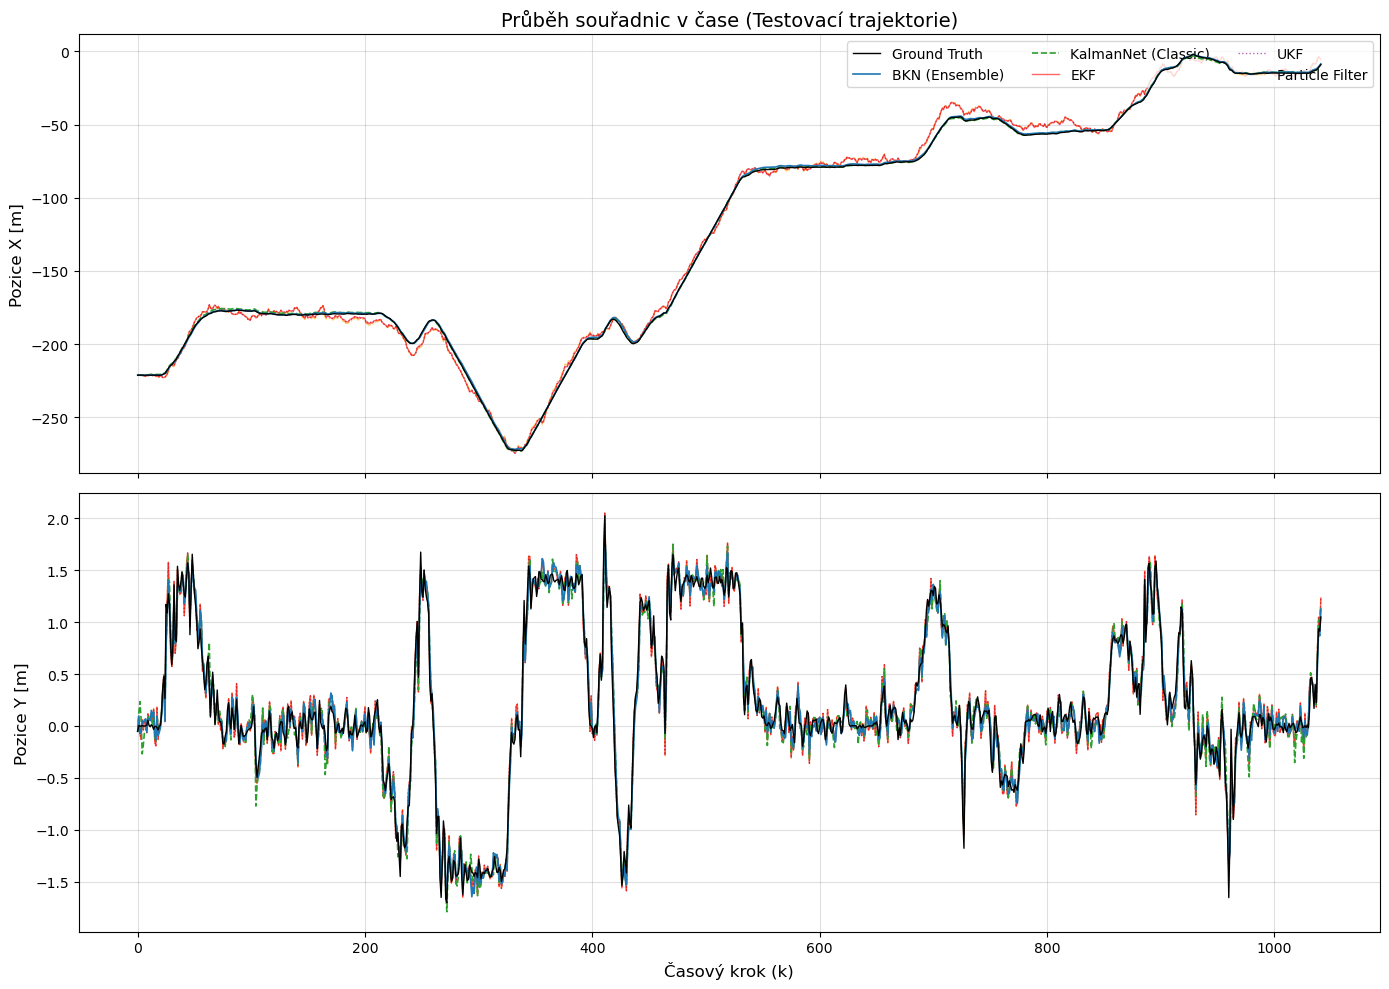

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ==============================================================================
# 4. VIZUALIZACE POZICE V ČASE (X vs T, Y vs T) - OPRAVENO
# ==============================================================================

# 1. Získání dat (převedeme na CPU numpy, pokud jsou to tenzory)
def to_np(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

# Ground Truth (z předchozího kroku)
gt_np = to_np(x_true)
bkn_np = to_np(x_bkn_mean)

# 2. Dopočítání masky výpadků (pokud chybí)
# Použijeme 'y_seq' z poslední iterace smyčky, která obsahuje měření
if 'gps_nan_mask' not in locals():
    # Předpokládáme, že y_seq je [T, Obs_Dim] a 1. sloupec je X z GPS
    # Pokud je v datech NaN, je to výpadek.
    current_gps = to_np(y_seq)
    gps_nan_mask = np.isnan(current_gps[:, 0])

# 3. Nastavení indexu (pokud je jen jedna trajektorie)
if 'TRAJ_IDX' not in locals():
    TRAJ_IDX = 0 

# Připravíme časovou osu
time_steps = np.arange(len(gt_np))

# Vytvoříme 2 podgrafy
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
coords_labels = ['Pozice X [m]', 'Pozice Y [m]']

# Definice stylů
styles = {
    'GT':   {'c': 'black', 'lw': 1.0, 'label': 'Ground Truth', 'zorder': 10},
    'BKN':  {'c': '#1f77b4', 'lw': 1.2, 'label': 'BKN (Ensemble)', 'zorder': 9},
    'KNet': {'c': '#2ca02c', 'lw': 1.2, 'ls': '--', 'label': 'KalmanNet (Classic)', 'zorder': 8},
    'EKF':  {'c': 'red', 'lw': 1.0, 'ls': '-', 'alpha': 0.6, 'label': 'EKF', 'zorder': 5},
    'UKF':  {'c': 'purple', 'lw': 1.0, 'ls': ':', 'alpha': 0.6, 'label': 'UKF', 'zorder': 4},
    'PF':   {'c': 'orange', 'lw': 1.0, 'ls': '-.', 'alpha': 0.6, 'label': 'Particle Filter', 'zorder': 3}
}

for i, ax in enumerate(axes):
    # 1. Ground Truth
    ax.plot(time_steps, gt_np[:, i], **styles['GT'])
    
    # 2. BKN
    ax.plot(time_steps, bkn_np[:, i], **styles['BKN'])
    
    # 3. KNet
    if 'x_knet_seq' in locals():
        knet_np = to_np(x_knet_seq)
        ax.plot(time_steps, knet_np[:, i], **styles['KNet'])
        
    # 4. Klasické filtry (pokud existují výsledky)
    if 'res_ekf' in locals():
        ekf_np = to_np(res_ekf['x_filtered'])
        ax.plot(time_steps, ekf_np[:, i], **styles['EKF'])
        
    if 'res_ukf' in locals():
        ukf_np = to_np(res_ukf['x_filtered'])
        ax.plot(time_steps, ukf_np[:, i], **styles['UKF'])
        
    if 'res_pf' in locals():
        pf_np = to_np(res_pf['x_filtered'])
        ax.plot(time_steps, pf_np[:, i], **styles['PF'])

    # Zvýraznění výpadků GPS (šedé pozadí)
    is_nan = np.concatenate(([0], gps_nan_mask, [0]))
    abs_diff = np.abs(np.diff(is_nan))
    ranges = np.where(abs_diff == 1)[0].reshape(-1, 2)
    
    for start, end in ranges:
        # Vykreslíme šedý pruh jen tam, kde je výpadek
        ax.axvspan(start, end, color='gray', alpha=0.15, label='GPS Výpadek' if (start == ranges[0][0] and i==0) else "")

    ax.set_ylabel(coords_labels[i], fontsize=12)
    ax.grid(True, alpha=0.4)
    
    # Legenda a titulek jen u horního grafu
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=3, fontsize=10)
        ax.set_title(f"Průběh souřadnic v čase (Testovací trajektorie)", fontsize=14)

axes[-1].set_xlabel("Časový krok (k)", fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Tvůj modul s filtry
from utils import utils # Tvůj modul pro ANEES

# ==============================================================================
# 0. KONFIGURACE A PŘÍPRAVA MODELŮ
# ==============================================================================
J_SAMPLES = 50  # Počet vzorků pro Ensemble
DT = 1.0        # Časový krok pro Dead Reckoning (NCLT má obvykle 1Hz po downsamplingu)

# Příprava modelů
try:
    trained_model_bkn = state_bkn
    trained_model_bkn.train() 
    print(f"INFO: BKN připraven (J={J_SAMPLES}).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_bkn' neexistuje.")

try:
    trained_model_classic = state_knet 
    trained_model_classic.eval() 
    print(f"INFO: KalmanNet (Classic) připraven.")
except NameError:
    trained_model_classic = None

print("Inicializuji EKF, UKF a PF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=10000)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA (S DR A BLIND TESTEM)
# ==============================================================================
metrics = {
    'BKN':  {'mse': [], 'anees': []},
    'KNet': {'mse': [], 'anees': []},
    'EKF':  {'mse': [], 'anees': []},
    'UKF':  {'mse': [], 'anees': []},
    'PF':   {'mse': [], 'anees': []},
    'DR':   {'mse': [], 'anees': []} # Přidáno Dead Reckoning
}

print(f"\nVyhodnocuji {len(test_loader.dataset)} sekvencí (Mód: GPS BLINDFOLD + DR Baseline)...")

with torch.no_grad():
    for batch_data in test_loader:
        if len(batch_data) == 3:
            x_true_batch, y_meas_batch, u_input_batch = batch_data
        else:
            x_true_batch, y_meas_batch = batch_data
            u_input_batch = torch.zeros(x_true_batch.shape[0], x_true_batch.shape[1], 4).to(device)

        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            y_seq_raw = y_meas_batch[i].to(device)
            x_true = x_true_batch[i].to(device)
            seq_len = y_seq_raw.shape[0]

            # === TEST SLEPOTY ===
            y_seq = y_seq_raw.clone()
            y_seq[:, 0] = 0.0  # Slepé GPS X
            y_seq[:, 2] = 0.0  # Slepé GPS Y

            # Inicializace
            init_state_row = x_true[0, :].unsqueeze(0) 
            init_state_col = x_true[0, :].unsqueeze(1) 
            
            # --- 0. Dead Reckoning (Baseline) ---
            # Čistá integrace rychlosti: x_t = x_{t-1} + v * dt
            dr_states = [x_true[0]] # Startujeme na GT
            curr_dr = x_true[0].clone()
            
            for t in range(1, seq_len):
                # Rychlost bereme z měření (index 1 a 3)
                vx = y_seq[t, 1]
                vy = y_seq[t, 3]
                
                # Update pozice
                curr_dr[0] += vx * DT
                curr_dr[2] += vy * DT
                # Update rychlosti v stavu (jen pro formu)
                curr_dr[1] = vx
                curr_dr[3] = vy
                
                dr_states.append(curr_dr.clone())
            
            dr_seq = torch.stack(dr_states)
            metrics['DR']['mse'].append(F.mse_loss(dr_seq[1:], x_true[1:]).item())
            metrics['DR']['anees'].append(np.nan) # DR nemá kovarianci -> ANEES nedefinováno

            # --- 1. Bayesian KalmanNet (BKN) ---
            bkn_init_batch = init_state_row.repeat(J_SAMPLES, 1) 
            trained_model_bkn.reset(batch_size=J_SAMPLES, initial_state=bkn_init_batch)
            samples_history = [bkn_init_batch] 
            
            for t in range(1, seq_len):
                y_t = y_seq[t].unsqueeze(0).repeat(J_SAMPLES, 1) 
                x_est_j, _ = trained_model_bkn.step(y_t) 
                samples_history.append(x_est_j)
            
            full_ensemble = torch.stack(samples_history, dim=0)
            x_bkn_mean = torch.mean(full_ensemble, dim=1) 
            residuals = full_ensemble - x_bkn_mean.unsqueeze(1)
            residuals_perm = residuals.permute(0, 2, 1) 
            P_bkn = torch.bmm(residuals_perm, residuals) / (J_SAMPLES - 1)
            
            metrics['BKN']['mse'].append(F.mse_loss(x_bkn_mean[1:], x_true[1:]).item())
            metrics['BKN']['anees'].append(utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0), x_bkn_mean[1:].unsqueeze(0), P_bkn[1:].unsqueeze(0)))

            # --- 2. KalmanNet (Classic) ---
            if trained_model_classic is not None:
                trained_model_classic.reset(batch_size=1, initial_state=init_state_row)
                knet_preds = [init_state_row]
                knet_covs = [sys_model.P0.unsqueeze(0)] 
                
                for t in range(1, seq_len):
                    y_t = y_seq[t].unsqueeze(0)
                    x_hat_t, P_hat_t = trained_model_classic.step(y_t)
                    knet_preds.append(x_hat_t)
                    knet_covs.append(P_hat_t)
                
                x_knet_seq = torch.stack(knet_preds, dim=0).squeeze(1)
                P_knet_seq = torch.stack(knet_covs, dim=0).squeeze(1)
                
                metrics['KNet']['mse'].append(F.mse_loss(x_knet_seq[1:], x_true[1:]).item())
                metrics['KNet']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), x_knet_seq[1:].unsqueeze(0), P_knet_seq[1:].unsqueeze(0)))

            # --- 3. Klasické Filtry ---
            try:
                res_ekf = ekf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['EKF']['mse'].append(F.mse_loss(res_ekf['x_filtered'][1:], x_true[1:]).item())
                metrics['EKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ekf['x_filtered'][1:].unsqueeze(0), res_ekf['P_filtered'][1:].unsqueeze(0)))
                
                res_ukf = ukf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['UKF']['mse'].append(F.mse_loss(res_ukf['x_filtered'][1:], x_true[1:]).item())
                metrics['UKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ukf['x_filtered'][1:].unsqueeze(0), res_ukf['P_filtered'][1:].unsqueeze(0)))
                
                res_pf = pf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['PF']['mse'].append(F.mse_loss(res_pf['x_filtered'][1:], x_true[1:]).item())
                metrics['PF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_pf['x_filtered'][1:].unsqueeze(0), res_pf['P_filtered'][1:].unsqueeze(0)))
            except Exception: pass 

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(l): return np.mean(l) if len(l)>0 else np.nan

print("\n" + "="*90)
print(f"VÝSLEDKY NA NCLT (GPS VYPNUTO - ČISTÁ ODOMETRIE)")
print("="*90)
print(f"{'Model':<25} | {'MSE':<15} | {'RMSE [m]':<15} | {'ANEES':<15}")
print("-" * 90)

# Nejprve Baseline
m_dr = avg(metrics['DR']['mse'])
rmse_dr = np.sqrt(m_dr) if not np.isnan(m_dr) else np.nan
print(f"{'Dead Reckoning':<25} | {m_dr:<15.4f} | {rmse_dr:<15.4f} | {'-':<15}")
print("-" * 90)

models_to_print = ['BKN', 'KNet', 'EKF', 'UKF', 'PF']
if trained_model_classic is None: models_to_print.remove('KNet')

for name in models_to_print:
    m = avg(metrics[name]['mse'])
    a = avg(metrics[name]['anees'])
    rmse = np.sqrt(m) if not np.isnan(m) else np.nan
    
    # Formátování ANEES (pokud je číslo příliš velké)
    anees_str = f"{a:<15.4f}" if a < 10000 else f"{a:<15.2e}"
    
    print(f"{name:<25} | {m:<15.4f} | {rmse:<15.4f} | {anees_str}")
print("="*90)

INFO: BKN připraven (J=50).
INFO: KalmanNet (Classic) připraven.
Inicializuji EKF, UKF a PF...

Vyhodnocuji 1 sekvencí (Mód: GPS BLINDFOLD + DR Baseline)...
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní ro